## **Import Libraries**

In [114]:
import re 
from typing import List, Dict, Optional
import numpy as np
from PIL import Image
import pytesseract
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import requests
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import json

## **Bank Classification**


In [115]:
def classify_bank(image_path: str, model, class_indices) -> str:
    if model is None:
        print("Bank classfication model not loaded. Returning 'Unknown'.")
        return "Unknown"
    
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_bank = class_indices[predicted_class_index]
        confidence = predictions[0][predicted_class_index]
        
        print(f"Predicted bank: {predicted_bank} with confidence: {confidence:.2f}")
        return predicted_bank
    except Exception as e:
        print(f"Error during bank classification: {e}")
        return "Unknown"

## **Image preprocessing**

In [ ]:
def preprocess_image(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image at {image_path}")

        h, w = img.shape[:2]
        img = img[int(h * 0.15):int(h * 0.8), int(w * 0.05):int(w * 0.8)]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        gray = cv2.resize(gray, None, fx=3.0, fy=3.0, interpolation=cv2.INTER_LANCZOS4)

        inverted = cv2.bitwise_not(gray)

        alpha = 0.9
        beta = 60
        adjusted = cv2.convertScaleAbs(inverted, alpha=alpha, beta=beta)

        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(adjusted, -1, kernel)

        normalized = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)

        return normalized
    
    except Exception as e:
        print(f"Error in preprocess_image: {e}")
        return None

## **Data Extraction Function**

In [117]:
def extract_data_aba(image):
    """Extract transaction details from a preprocessed ABA Bank receipt image."""
    # OCR configuration
    config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz:,.|() '
    
    try:
        # Extract text using OCR
        text = pytesseract.image_to_string(image, config=config).strip()

        # Regex patterns
        patterns = {
            "transaction_id": r":\s*Trx\.ID[:\s]*(\d+)",  
            "amount": r"([\d.]+)\s*(USD|KHR)",  
            "date": r"Transaction\s*date[:\s]*([A-Za-z]+\s*\d{1,2},\s*\d{4}\s*\|\s*\d{1,2}:\d{2}[a-zA-Z]*)",  
            "paid_from": r"Paid\s*from[:\s]*([^.]+)\.\s*\(([\d\s]+)\)",  
        }

        data = {}
        for key, pattern in patterns.items():
            match = re.search(pattern, text, re.IGNORECASE)
            if match:  
                if key == "amount":
                    amount_str = match.group(1)
                    currency = match.group(2)
                    data[key] = f"{float(amount_str)} {currency}"
                    data["amount"] = float(amount_str)
                elif key == "paid_from":
                    data[key] = f"{match.group(1).strip()} ({match.group(2).strip()})"
                else:
                    data[key] = match.group(1).strip()
            else:
                 
                data[key] = "None" if key != "amount" else 0.0

        return data
    except Exception as e:
        print(f"Error in extract_data_aba: {e}")
        return {
            "transaction_id": "None",
            "amount": 0.0,
            "date": "None",
            "paid_from": "None"
        }

## **Testing Function**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Predicted bank: ABA Bank with confidence: 1.00


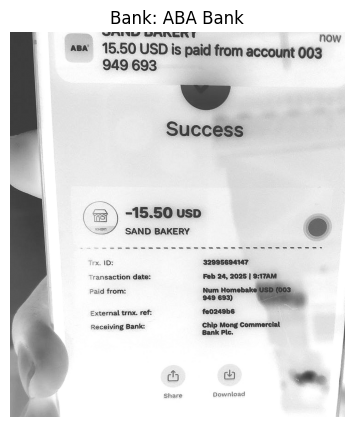

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 15.5,
  "date": "Feb24,2025 |9:17AM",
  "paid_from": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted bank: ABA Bank with confidence: 1.00


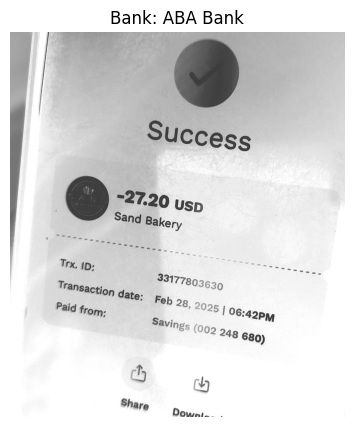

Extracted Transaction Data:
{
  "transaction_id": "3317780365",
  "amount": 27.2,
  "date": "Feb 28, 2095 | 06:42ppy",
  "paid_from": "Saving (0092 248 680)"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted bank: ABA Bank with confidence: 1.00


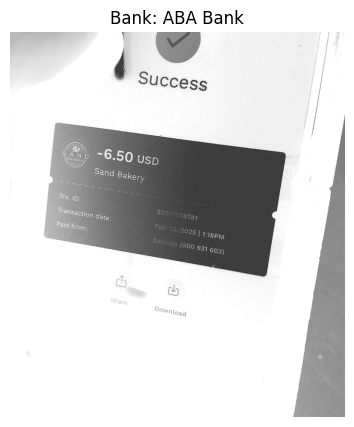

Extracted Transaction Data:
{
  "transaction_id": "None",
  "amount": 0.0,
  "date": "None",
  "paid_from": "None"
}
Total amount: 42.7


In [118]:
model_path = "../src/backend/models/bank_classification.h5"
model = load_model(model_path)

CLASS_INDEXES = ["ABA Bank", "ACLIDA Bank", "Other"]

folder_path = "../data/raw/Test II/"

# Get all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.png'))]

amount = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    
    preprocessed_image = preprocess_image(image_path)
    if preprocessed_image is None:
        print(f"Skipping {image_file} due to preprocessing error.")
        continue
    
    # Extract data if the bank is classified as "ABA Bank"
    if classified_image == "ABA Bank":
        extracted_data = extract_data_aba(preprocessed_image)
    else:
        extracted_data = {
            "transaction_id": "None",
            "amount": 0.0,
            "date": "None"
        }
    
    # Display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()
    
    print(f"Extracted Transaction Data:\n{json.dumps(extracted_data, indent=2)}")
    
    amount.append(extracted_data['amount'])

print(f"Total amount: {sum(amount)}")

## **Clean Extracted Data Function**

In [119]:
def clean_extracted_data(extracted_data_list):
    
    cleaned_data = []
    total_amount = 0.0

    for data in extracted_data_list:
        # Ensure all keys are present
        transaction_id = data.get("transaction_id", "None")
        amount = data.get("amount", 0.0)
        date = data.get("date", "None")
        paid_from = data.get("paid_from", "None")

        # Validate and clean the amount
        try:
            amount = float(amount) if isinstance(amount, (int, float, str)) and amount != "None" else 0.0
        except ValueError:
            amount = 0.0

        # Add to total amount if valid
        if amount > 0:
            total_amount += amount

        # Append cleaned data
        cleaned_data.append({
            "transaction_id": transaction_id,
            "amount": amount,
            "date": date,
            "paid_from": paid_from
        })

    # Summary
    summary = {
        "total_amount": total_amount,
        "valid_transactions": len([d for d in cleaned_data if d["amount"] > 0]),
        "cleaned_data": cleaned_data
    }

    return summary

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted bank: ABA Bank with confidence: 1.00


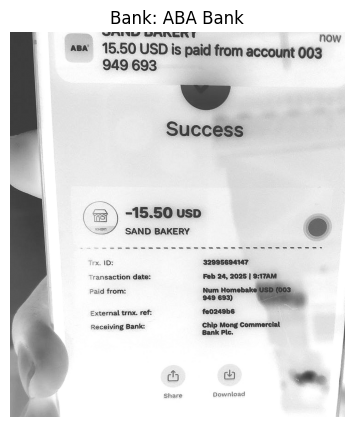

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted bank: ABA Bank with confidence: 1.00


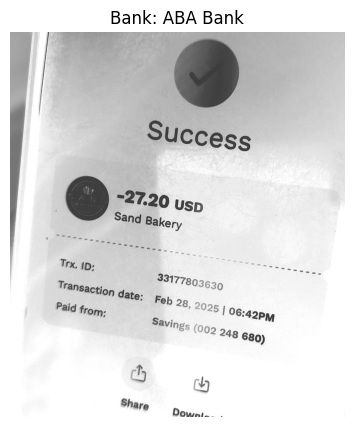

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted bank: ABA Bank with confidence: 1.00


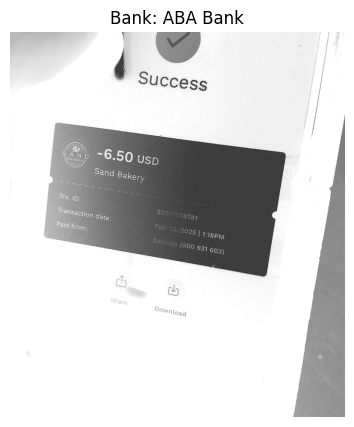

Cleaned Data:
[
  {
    "transaction_id": "None",
    "amount": 15.5,
    "date": "Feb24,2025 |9:17AM",
    "paid_from": "None"
  },
  {
    "transaction_id": "3317780365",
    "amount": 27.2,
    "date": "Feb 28, 2095 | 06:42ppy",
    "paid_from": "Saving (0092 248 680)"
  },
  {
    "transaction_id": "None",
    "amount": 0.0,
    "date": "None",
    "paid_from": "None"
  }
]


In [122]:
# List to store all extracted data
extracted_data_list = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    preprocessed_image = preprocess_image(image_path)
    
    if preprocessed_image is None:
        print(f"Skipping {image_file} due to preprocessing error.")
        continue
    
    if classified_image == "ABA Bank":
        extracted_data = extract_data_aba(preprocessed_image)
    else:
        extracted_data = {
            "transaction_id": "None",
            "amount": "0.0 USD",
            "date": "None",
            "paid_from": "None"
        }
    
    # Append extracted data to the list
    extracted_data_list.append(extracted_data)

    # Display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()

# Clean and summarize the extracted data
summary = clean_extracted_data(extracted_data_list)

# Print the cleaned data
print("Cleaned Data:")
print(json.dumps(summary['cleaned_data'], indent=2))